# Final Project Wine

Executive Summary:

My goal is to analyze this data from wine mag. It originally featured 150K wines and broke down their points, price, and where they are from. I cleaned up the data to strip down outliers in price (very high ones, and where all the prices are zero.

After cleaning the data and making some plots of comparing the price to some of the other variables, namely the points, I decided to create a model to try to predict price.

I did logistic regression and grid search CV to test my model.


## Import the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


#importing things that will be useful here

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


where the data came from: https://www.kaggle.com/zynicide/wine-reviews/version/4

In [2]:
df = pd.read_csv('winemag-data_first150k.csv')
print(df.shape)
df.head()
#importing my file and previewing it

(150930, 11)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


note a lot of the prices are NaN - cleaning this will be important for the analysis

## Clean the data

In [3]:
df.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


In [4]:
df = df.dropna()
#for now instead of cleaning out NaN prices, we are just going to remove them.

In [5]:
#change price from a float value to an integer
df['price'] = df['price'].astype(int)

In [6]:
df.head()
#show a sample of the data frame now that NaN's are gone

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


In [7]:
len(df)


39241

The data without the rows that have NaN price is 39,241 - which is significantly smaller data set than the original.

## Plot the Data

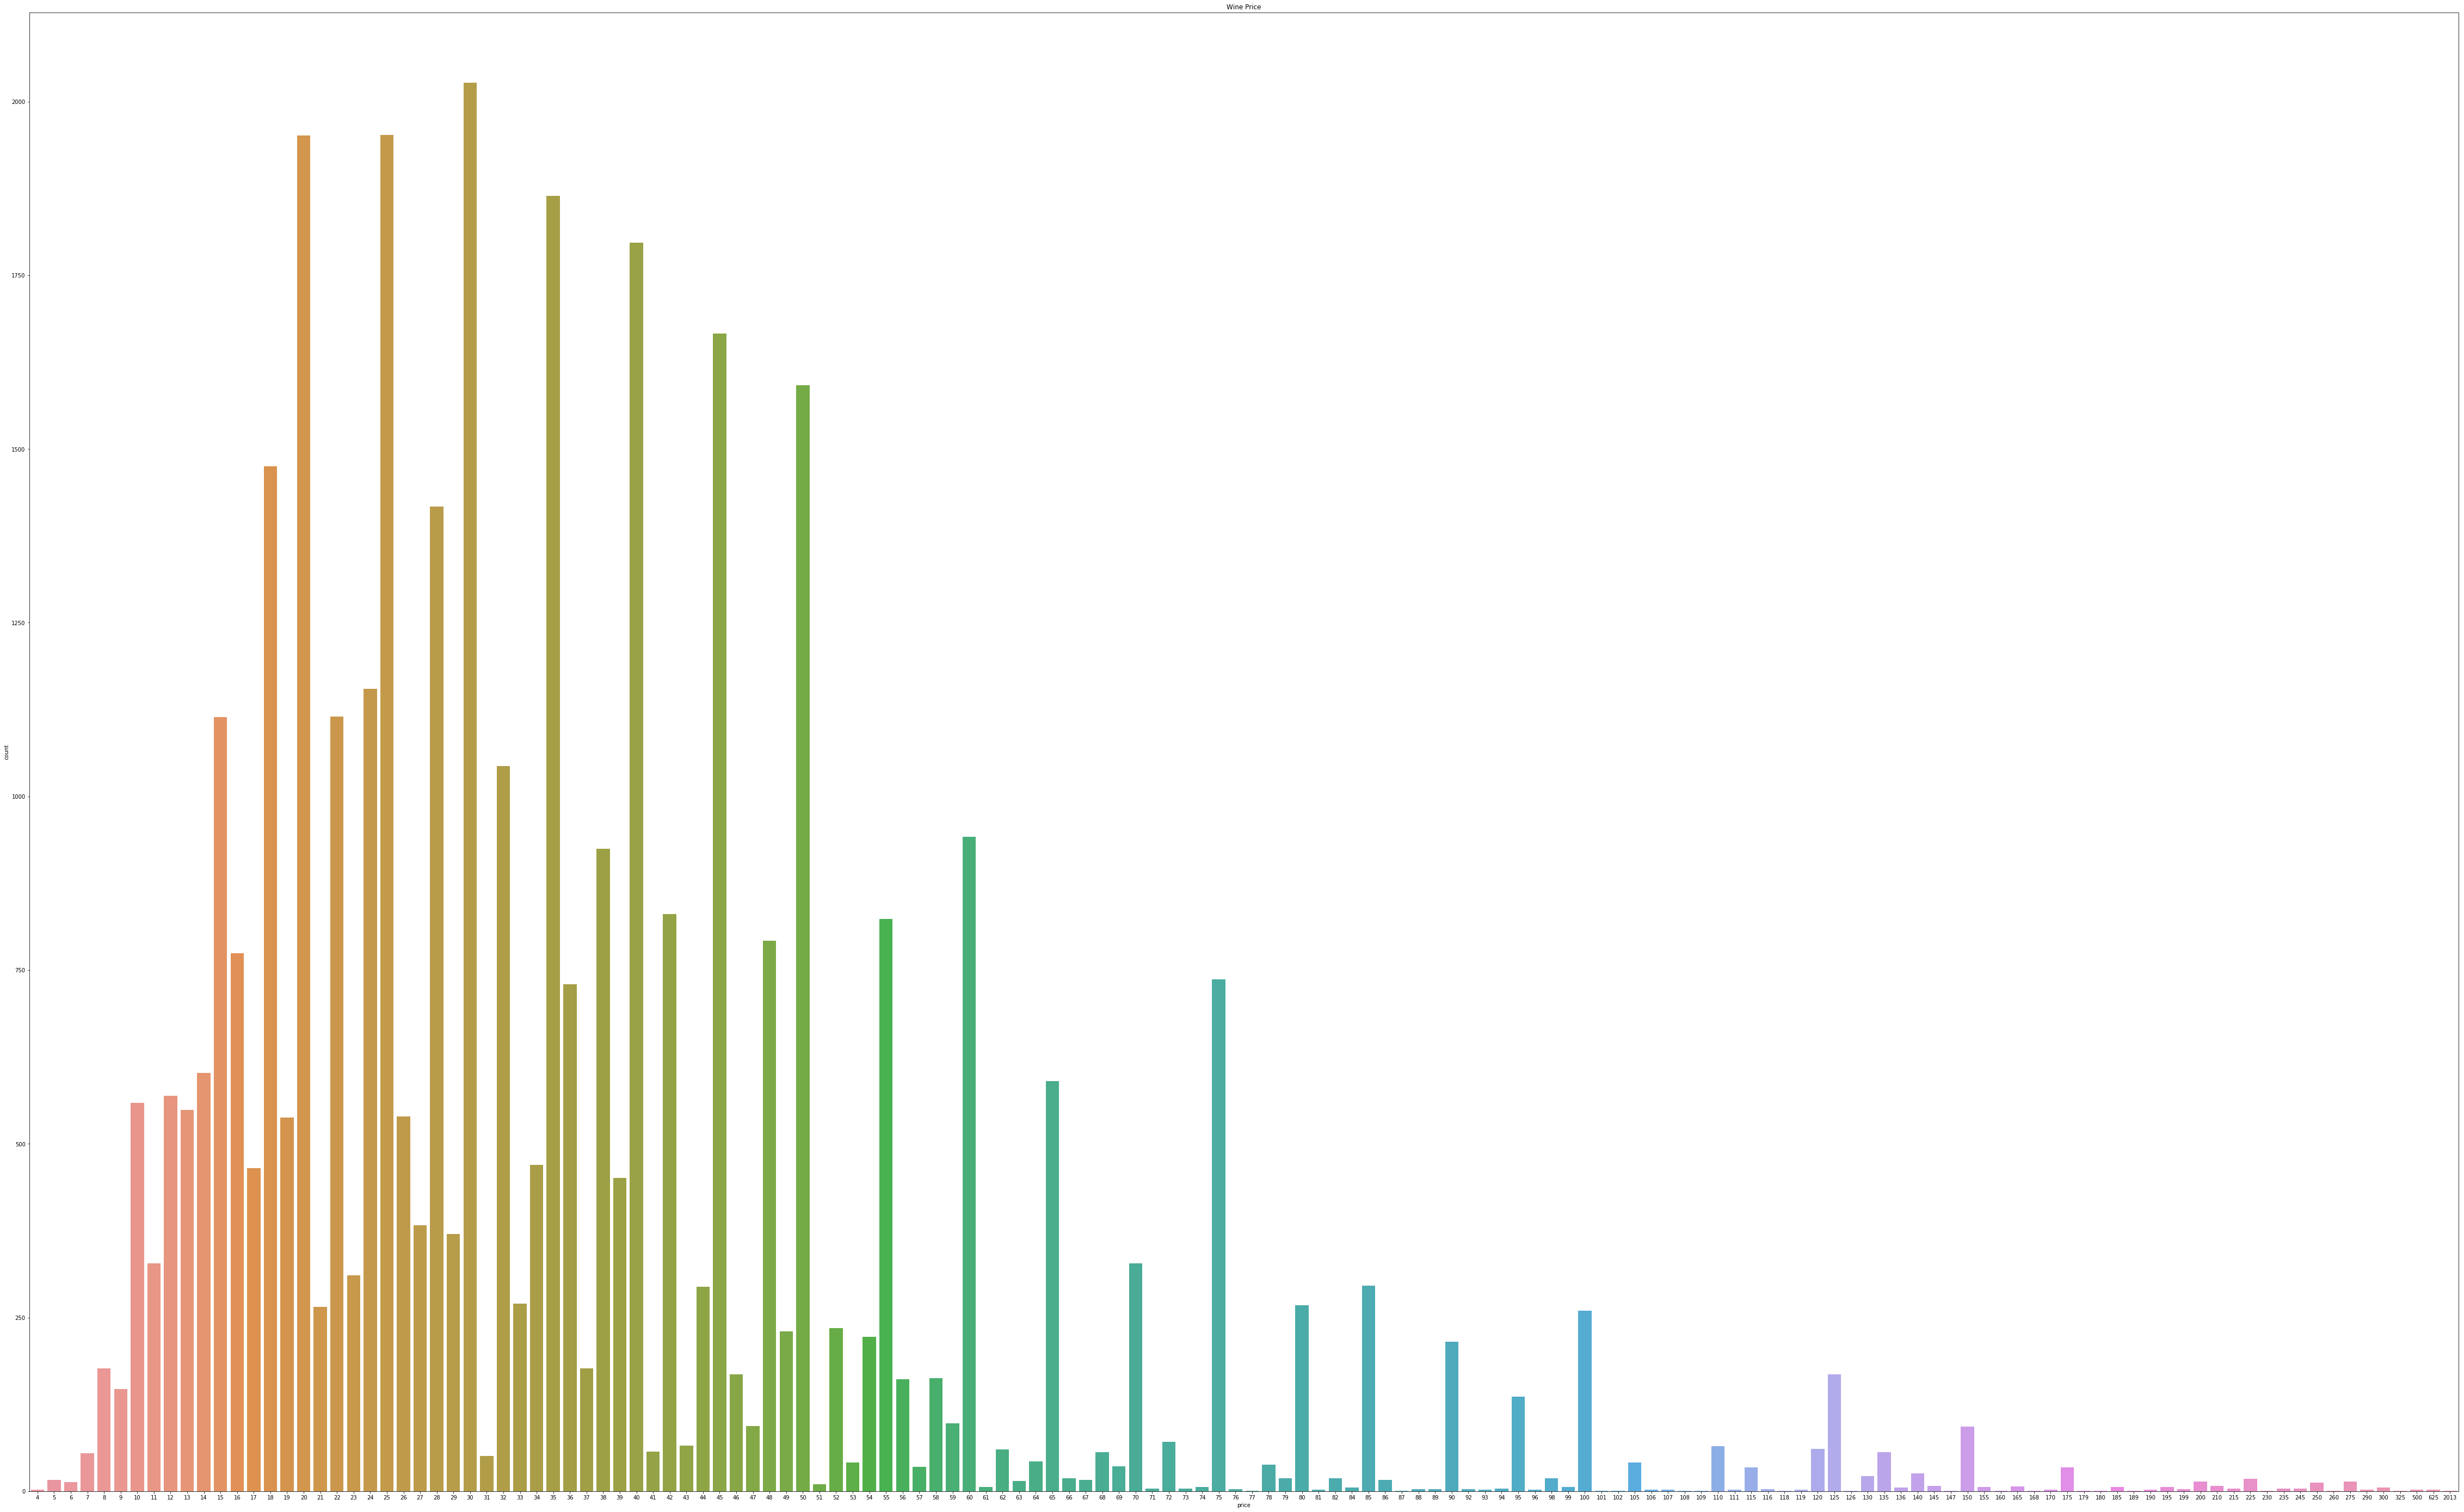

In [8]:
plt.figure(figsize=(80,50))
plt.title("Wine Price")
ax = sns.countplot(x = 'price', data = df )

In [9]:
#how many times each price comes up (price is to the left count is to the right)
df['price'].value_counts().sort_index()

4          2
5         16
6         13
7         55
8        177
9        147
10       559
11       328
12       569
13       549
14       602
15      1114
16       774
17       465
18      1475
19       538
20      1951
21       265
22      1115
23       311
24      1155
25      1952
26       539
27       383
28      1417
29       370
30      2027
31        51
32      1044
33       270
        ... 
150       93
155        6
160        1
165        7
168        1
170        2
175       34
179        1
180        1
185        6
189        1
190        2
195        6
199        3
200       14
210        8
215        4
225       18
230        1
235        4
245        4
250       12
260        1
275       14
290        2
300        5
325        1
500        2
625        2
2013       1
Name: price, Length: 146, dtype: int64

limit the data, I don't want to use the 2013 outlier because it is so much higher than the next highest value and could skew my results.
I decided to check the price frequencies for the prices less than and equal to $200. Anything else is not considered.

In [10]:
df = df[(df['price'] <=200)]

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:90: UserWarning: 'stat_bin()' using 'bins = 145'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_c

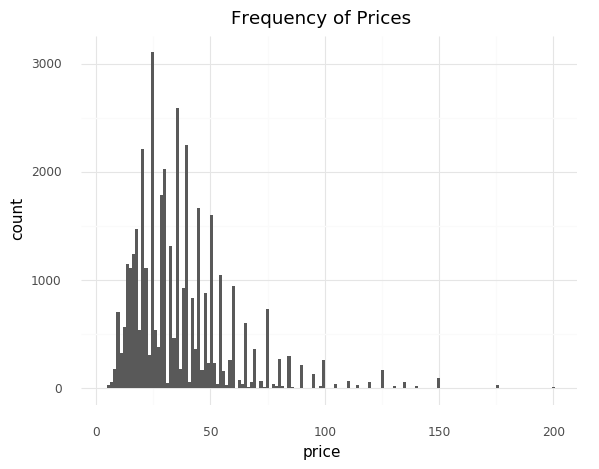

<ggplot: (164767488106)>

In [11]:
(ggplot(df, aes(x='price'))
+ geom_histogram()
+ ggtitle('Frequency of Prices')
+ theme_minimal()
)

## Some more charts and analysis of mode

In [12]:
plt_df = (df
         .groupby(['price'])
         .apply(lambda x: pd.Series(dict(
             count = x.shape[0]
         )))
          .reset_index()
         )

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:431: UserWarning: position_stack : Removed 14 

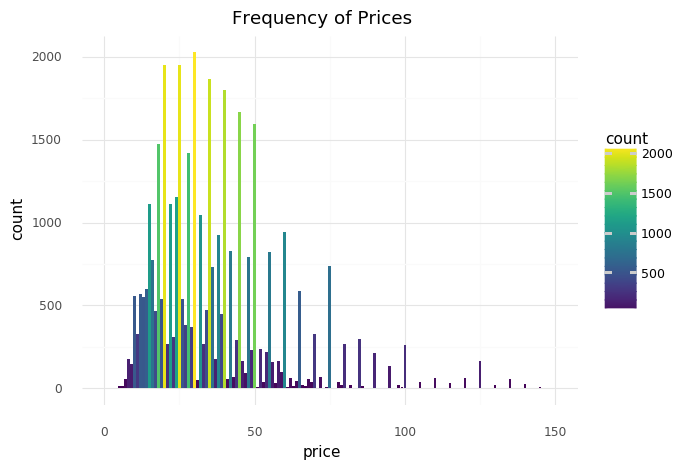

<ggplot: (-9223371872079731312)>

In [13]:
(ggplot(plt_df, aes(x='price', y='count', fill='count'))
+ geom_bar(stat='identity')
+ ggtitle('Frequency of Prices')
+ theme_minimal()
+ xlim(0, 150)
)

In [14]:
df.mode()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,2,US,"A Southern Rhône-style blend of Syrah, Grenach...",Reserve,87.0,30.0,California,Napa Valley,Central Coast,Pinot Noir,Williams Selyem
1,3,NaN,A barrel selection from the 30-acre estate vin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,NaN,"A blend from two well-regarded vineyards, this...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,A blend of four traditional Portuguese grape v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,"A blend of three vineyard sites, this fragrant...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12,NaN,"A dark, dry, tannic and rustic wine, made from...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14,NaN,"A delicious, balanced Pinot Noir. Shows dry, p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,NaN,"A dusty, cigar-smoke character on the nose of ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19,NaN,"A feminine wine, soft, gentle and delicious in...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20,NaN,"A flamboyantly rich red wine, brimming with ri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


the mode price is $30 and the mode points is 87. We see these figures in the first line of the above chart and the rest of the NaN lines are not very helpful but at least we see what we wanted to know in the first row!

In [15]:
plt_df = (df
         .groupby(['points'])
         .apply(lambda x: pd.Series(dict(
             count = x.shape[0]
         )))
          .reset_index()
         )

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\positions\position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


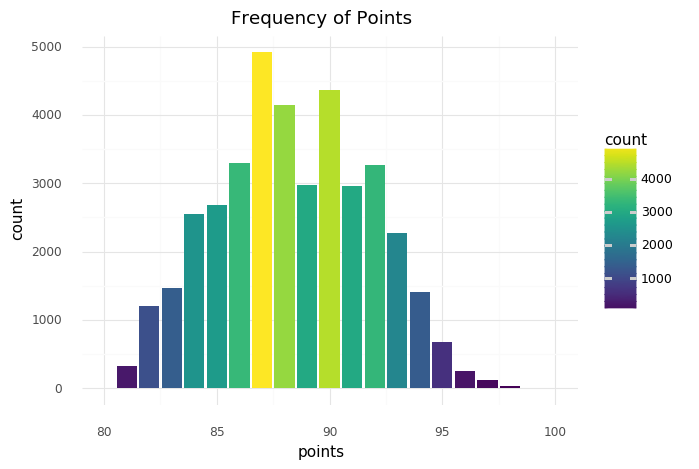

<ggplot: (-9223371872079682914)>

In [16]:
(ggplot(plt_df, aes(x='points', y='count', fill='count'))
+ geom_bar(stat='identity')
+ ggtitle('Frequency of Points')
+ theme_minimal()
+ xlim(80, 100)
)

## Data Prep

deterine the quantiles to see what a good categorical cutoff price would be for regerssion

In [17]:
df[['price']].quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

price    32.0
Name: 0.5, dtype: float64

In [18]:
df[['price']].quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')

price    22.0
Name: 0.25, dtype: float64

In [19]:
df[['price']].quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

price    45.0
Name: 0.75, dtype: float64

based on this, 30 seems like a good cutoff point. A $30 price is right below the 50 quantile/

convert price which is now numbers into 0 or 1

if price is less than 30 it is 0
if price is more than 30 is 1
use regression to predict price as is
switch y variable to linear and logistic regression

In [20]:
df['price_under_30'] = (df['price'] <= 30).astype(int)

In [21]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_under_30
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,0
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,0
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,0
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,0
11,11,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48,Oregon,Ribbon Ridge,Willamette Valley,Pinot Noir,Patricia Green Cellars,0


In [22]:
df.shape

(39162, 12)

There are 39,162 rows of cleaned data with 12 columns each

In [23]:
input_variables = ['country', 'description', 'designation', 'points', 'province', 'region_1', 'region_2', 'variety', 'winery', 'price_under_30']

Inputted the variables that would be considered in this. I chose the price under 30 as my y (note this is a newly added variable, not the same as the original price variable). The X items in the matrix I chose are points, province, region_1, and winery. Originally, I chose only points, province, and region_1 because with the fewer X items in the matrix, the faster the models would run. However, with more X items, the more accurate my models are. As I continued working with the data I came back to the patsy import for my matrix and added the winery variable back in. While it may take longer for the cells to load I appreciate the more accuarte model.

In [24]:
from patsy import dmatrices
y, X = dmatrices('price_under_30 ~ points + province + region_1 + winery',
                  df, return_type = "dataframe")

In [25]:
X.head()

,Intercept,province[T.New York],province[T.Oregon],province[T.Washington],region_1[T.Alexander Valley],region_1[T.Alta Mesa],region_1[T.Amador County],region_1[T.Amador-Napa],region_1[T.Ancient Lakes],region_1[T.Anderson Valley],...,winery[T.flipflop],winery[T.j.brix],winery[T.kukkula],winery[T.l'homme qui ris],winery[T.love & squalor],winery[T.un4seen],winery[T.Écluse],winery[T.Élevée Winegrowers],winery[T.àMaurice],points
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0


In [26]:
X.shape

(39162, 3604)

This represents the size of the matrix. If we added X variables it would get longer! 

In [27]:
y.shape

(39162, 1)

In [28]:
# Doc: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
import sklearn
print(sklearn.__version__)

0.19.2


The cell below assigns my test and train variables so that I can set up and run a model

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Classification

Now that the data is clean and I have assigned my train and test variables, I can begin the regression and classification.

I first ran a logistic regression.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logreg = LogisticRegression()

I fit the logistic regression to my train variables that I assigned above

In [32]:
# Train the model using the training sets
logreg.fit(X_train, y_train)

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
# The coefficients
print("Variables names: \n", input_variables) 
print('Coefficients: \n', logreg.coef_)

Variables names: 
 ['country', 'description', 'designation', 'points', 'province', 'region_1', 'region_2', 'variety', 'winery', 'price_under_30']
Coefficients: 
 [[ 9.7256412   1.63290892  0.15466602 ... -0.09418759 -1.19153698
  -0.22270563]]


I got the coefficients of my logistic regression and then plot the confusion matrix using gg plot.

In [34]:
def plot_confusion_matrix(cm, normalize=True, digits=4):
    plt_df = (pd.DataFrame(cm)
              .reset_index()
              .melt(id_vars='index')
              .assign(index = lambda d: pd.Categorical(d['index'], d['index'].unique()[::-1], ordered=True),
                      variable = lambda d: pd.Categorical(d['variable'], d['variable'].unique(), ordered=True))
              .rename(columns={'index':'true label', 'variable':'predicted label'})
             )
    
    if normalize:
        plt_df = (plt_df
                  .assign(true_total = lambda d: d.groupby('true label')['value'].transform(lambda x: x.sum()))
                  .assign(value = lambda d: (d['value'] / d['true_total']).round(digits))
                 )
        
    plt = (ggplot(plt_df, aes(x='predicted label', y='true label'))
            + geom_tile(aes(fill='value')) 
            + geom_text(aes(label='value'))
            + theme_minimal()
            + scale_fill_gradient(low = "snow", high = "steelblue")
            + theme(legend_title=element_blank())
           )
    
    return plt

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


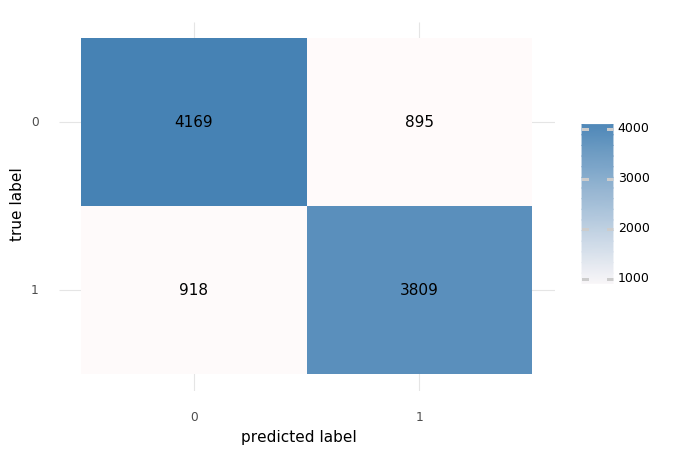

<ggplot: (164775089535)>

In [35]:
pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, normalize=False)

The confusion matrix has strong blue squares in the top left and bottom right. This is where the model made correct predictions of false and true for predicting whether the price was above or below $30

Now I tested the accuracy, precision, recall, fscore, etc. of the Logistic regression. The testing accuracy is 81% which is pretty good! Before I added in the winery X matrices variable the accuracy was in the 70% range. this is where we can see adding the variable adds to accuracy. 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

In [37]:
preds_train = logreg.predict(X_train)
preds_test = logreg.predict(X_test)
print(classification_report(y_train, preds_train))
print(classification_report(y_test, preds_test))

print('Training precision:', precision_score(y_train, preds_train))
print('Training recall:', recall_score(y_train, preds_train))
print('Training accuracy:', accuracy_score(y_train, preds_train))
print('Training F1:', f1_score(y_train, preds_train))
print('Testing precision:', precision_score(y_test, preds_test))
print('Testing recall:', recall_score(y_test, preds_test))
print('Testing accuracy:', accuracy_score(y_test, preds_test))
print('Testing F1:', f1_score(y_test, preds_test))

             precision    recall  f1-score   support

        0.0       0.85      0.85      0.85     15230
        1.0       0.84      0.83      0.84     14141

avg / total       0.84      0.84      0.84     29371

             precision    recall  f1-score   support

        0.0       0.82      0.82      0.82      5064
        1.0       0.81      0.81      0.81      4727

avg / total       0.81      0.81      0.81      9791

Training precision: 0.8371069628788417
Training recall: 0.8340287108408175
Training accuracy: 0.8419529467842429
Training F1: 0.8355650017711654
Testing precision: 0.8097363945578231
Testing recall: 0.805796488258938
Testing accuracy: 0.8148299458686549
Testing F1: 0.8077616371540663


In [38]:
%%time
params = { 
    'n_estimators': [25, 50],
    'subsample': [0.25, 0.5],
    'max_depth' : [2, 4],
    'min_samples_split': [50],
    'min_samples_leaf': [50]
}

mod = GradientBoostingClassifier()
gscv = GridSearchCV(mod, params, cv=2, verbose=2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.25 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.25, total=  16.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.25, total=  16.8s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.5 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.5, total=  25.4s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.5 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=25, subsample=0.5, total=  25.4s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50, subsample=0.25 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50, subsample=0.25, total=  28.8s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50, subsample=0.25 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50, subsample=0.25, total=  28.7s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50, subsa

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 10.5min finished


Wall time: 13min 47s


This grid search CV takes a LONG time to run! That's because there are a lot of X variables and the n estimators are fairly high. The n estimators are the number of times estimating through my depth. Going through the depth a high number of times leads to a more accurate model. I also only put in one option for my subsample, min sample split, and min sample leaf. If I had more options in these it would also take longer to load the model; however it would also probably have a higher accuracy. 

In [39]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Train score: 0.7296653992779785
Test score: 0.7259882196724661


C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

Now this prints the best estimator of the grid search model. 

C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\kdica\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


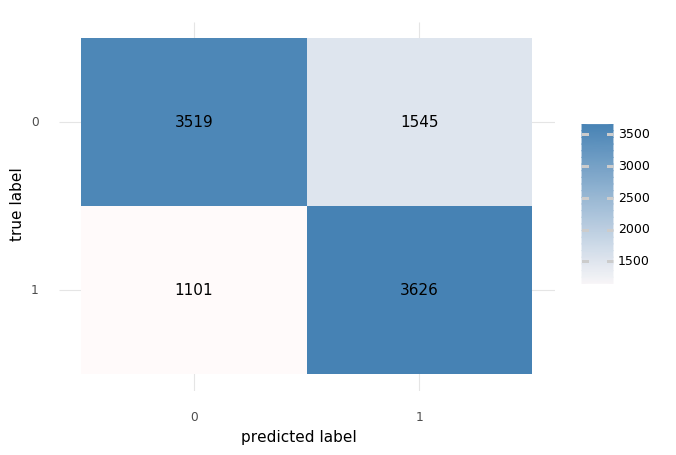

<ggplot: (164775118607)>

In [40]:
pred = gscv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, normalize=False)

In [41]:
cm

array([[3519, 1545],
       [1101, 3626]], dtype=int64)

In [42]:
y_train

,price_under_30
53894,0.0
86293,1.0
39367,0.0
94249,0.0
23500,1.0
27733,1.0
127171,1.0
141032,0.0
86002,1.0
90632,1.0


In [43]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,16.268406,0.366476,0.213722,0.010686,2,50,50,25,0.25,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.700531,0.712155,0.706343,0.005812,7,0.711747,0.701961,0.706854,0.004893
1,25.302311,0.038289,0.204734,0.001566,2,50,50,25,0.5,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.699510,0.710453,0.704981,0.005472,8,0.710385,0.701621,0.706003,0.004382
2,28.613563,0.036667,0.238814,0.010517,2,50,50,50,0.25,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.710132,0.718148,0.714140,0.004008,5,0.719374,0.713877,0.716625,0.002748
3,47.140945,0.159339,0.246668,0.003661,2,50,50,50,0.5,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.709451,0.719374,0.714412,0.004961,4,0.720667,0.713877,0.717272,0.003395
4,27.776670,0.124702,0.303702,0.038383,4,50,50,25,0.25,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.706387,0.715560,0.710973,0.004587,6,0.714947,0.710541,0.712744,0.002203
5,42.703433,0.899575,0.223659,0.020580,4,50,50,25,0.5,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.713469,0.717603,0.715536,0.002067,3,0.722846,0.716260,0.719553,0.003293
6,42.882311,0.012336,0.241541,0.007225,4,50,50,50,0.25,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.719869,0.725026,0.722447,0.002578,2,0.723732,0.720686,0.722209,0.001523
7,80.959371,0.318287,0.307236,0.021997,4,50,50,50,0.5,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.725589,0.726387,0.725988,0.000399,1,0.732108,0.727223,0.729665,0.002442


## Correlation

In [44]:
df[['points', 'price']].corr()

,points,price
points,1.000000,0.484261
price,0.484261,1.000000


[[1.         0.48426117]
 [0.48426117 1.        ]]


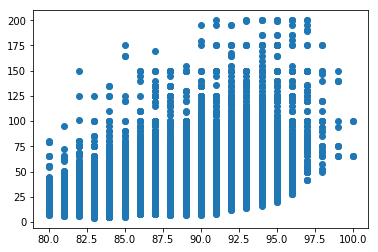

In [45]:
x , y = df['points'], df['price']
print(np.corrcoef(x,y))
plt.scatter(x,y)

Observation: the price and the points are not closely correlated.

Conclusion: I'm trying to predict if I could use the features of a bottle of wine to predict if the price is above or below $30. The features I used were the categegorical variables were region, winery, etc.

I created a matrix to test the price around $30 compared to several of the qualifiers available in the data. Then I ran 2 different models and evaluated the accuracy of the test scores for both. My logistic regression and my grid search CV were both fairly accurate.

